In [1]:
#import all necessary items from Su's code:
#from xd import *
#from utils import *
import esutil, yaml, sys, os, argparse
import healpy as hp
#from systematics import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import astropy.io.fits as fits

#opening CMASS catalog:
fitsfile='/fs/scratch/cond0080/galaxy_DR11v1_CMASS_South-photoObj.fits'
hdu=fits.open(fitsfile)

import h5py

#opening DES catalog:
filename='/fs/scratch/PCON0003/warner785/Y3_mastercat_03_31_20.h5'
f=h5py.File(filename,'r')

#read in values:
modelmag_g_des=f['catalog/gold/sof_cm_mag_corrected_g'][:]
modelmag_r_des=f['catalog/gold/sof_cm_mag_corrected_r'][:]
modelmag_i_des=f['catalog/gold/sof_cm_mag_corrected_i'][:]

'''
magmodel=hdu[1].data['CMODELMAG']
cmodelmag_g_des=magmodel[:,0]
cmodelmag_r_des=magmodel[:,1]
cmodelmag_i_des=magmodel[:,2]
'''

cmodelmag_g_des=modelmag_g_des
cmodelmag_r_des=modelmag_r_des
cmodelmag_i_des=modelmag_i_des
magauto_des=modelmag_i_des


#defining the cut:

cut = (((cmodelmag_r_des>16)&(cmodelmag_r_des<24))&((cmodelmag_i_des>16)&(cmodelmag_i_des<24))&((cmodelmag_g_des>16)&(cmodelmag_g_des<24))&((modelmag_r_des-modelmag_i_des)<1.5)&((modelmag_r_des-modelmag_i_des)>0.)&((modelmag_g_des-modelmag_r_des)>0.)&((modelmag_g_des-modelmag_r_des)<2.5)&(magauto_des<21.5))

#matching catalogs (train_st82):
'''
#Su's flags and color cut:
mask_all=cut
f'=f[cut]
train_sample=fitsfile
#print('total num of train', len(train_sample))
'''
#reading in needed values:
cmass_ra=hdu[1].data['RA     ']
cmass_dec=hdu[1].data['DEC    ']
ra=f['catalog/gold/ra'][:][cut]
dec=f['catalog/gold/dec'][:][cut]

mg1, mg2,_= esutil.htm.HTM(10).match(cmass_ra, cmass_dec, ra, dec, 2./3600, maxmatch=1)

cmass_mask=np.zeros(ra.size, dtype=bool)
cmass_mask[mg2]=1
clean_cmass_data_des_ra, nocmass_ra=ra[cmass_mask], ra[~cmass_mask]
clean_cmass_data_des_dec, nocmass_dec=dec[cmass_mask], dec[~cmass_mask]

print(('num of cmass in des side', clean_cmass_data_des_ra.size, '({:0.0f}%)'.format(clean_cmass_data_des_ra.size*1./cmass_ra.size*100.)))



('num of cmass in des side', 56335, '(30%)')


IndexError: boolean index did not match indexed array along dimension 0; dimension is 188582 but corresponding boolean dimension is 399263026

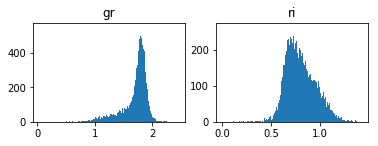

In [6]:

#visualizing the map of location overlap:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np


plt.plot(clean_cmass_data_des_ra, clean_cmass_data_des_dec,'k.')
#plt.plot(ra,dec,'r.')
plt.title('Overlap of DES and CMASS')
#plt.xlim(0,3.0)
#plt.ylim(0,1.6)
#plt.show()

#creating figure 1 from Su's paper:

flags_foreground=f['catalog/gold/flags_foreground'][:]
flags_badregions=f['catalog/gold/flags_badregions'][:]
flags_gold=f['catalog/gold/flags_gold'][:]
flags_footprint=f['catalog/gold/flags_footprint'][:]

#good=(flags_foreground[cut]==0)&(flags_badregions[cut]<2)&(flags_gold[cut]<8)&(flags_footprint[cut]==1)&(cmass_mask)
good=cmass_mask

#%matplotlib inline
from matplotlib import colors

plt.subplot(221)
plt.hist(modelmag_g_des[cut][good]-modelmag_r_des[cut][good],1000)
plt.title('gr')
plt.subplot(222)
plt.hist(modelmag_r_des[cut][good]-modelmag_i_des[cut][good],1000)
plt.title('ri')

#BOSS magnitudes:
magmodel=hdu[1].data['CMODELMAG']
cmodelmag_g_des=magmodel[:,0]
cmodelmag_r_des=magmodel[:,1]
cmodelmag_i_des=magmodel[:,2]

cgr=cmodelmag_g_des[cut][good]-cmodelmag_r_des[cut][good]
cri=cmodelmag_r_des[cut][good]-cmodelmag_i_des[cut][good]

plt.hist2d(cgr,cri,bins=(1000,1000))
cmap=plt.cm.jet
plt.colorbar()

# d_perp cut:
d_perp=cri-(cgr/8.0)

plt.xlabel('g-r')
plt.ylabel('r-i')
plt.title('BOSS')
plt.xlim(0,3.0)
plt.ylim(0,1.6)
plt.show()

#matched DES magnitudes:
plt.figure()
gr=modelmag_g_des[good]-modelmag_r_des[good]
ri=modelmag_r_des[good]-modelmag_i_des[good]

plt.hist2d(gr,ri,bins=(1000,1000))
cmap=plt.cm.jet
plt.colorbar()

plt.xlabel('g-r')
plt.ylabel('r-i')
plt.title('DES')
plt.xlim(0,3.0)
plt.ylim(0,1.6)
plt.show()